In [1]:
import numpy as np
from scipy.special import erf
import os
import sys
import time
import copy
import logging
import matplotlib.pyplot as plt

# Navigate to the parent directory of the project structure
project_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_dir = os.path.join(project_dir, 'src')
log_dir = os.path.join(project_dir, 'log')
fig_dir = os.path.join(project_dir, 'fig')

# Add the src directory to sys.path
sys.path.append(src_dir)

from estimator.Exponential import ExpEstimator
from analysis.commons import batch_estimator_estimated_delta, compute_bootstrap_range
from utils.constants import WORKERS

In [2]:
def generate_default_configuration():
    claimed_epsilon = 0.02
    epsilon = 2
    gamma = 0.01

    dataset_settings = {
        'database_0': np.array([0, 1, 1]),
        'database_1': np.array([0, 1]),
        'outcomes_size': 3,
        'sensitivity': 1,
        'epsilon': epsilon,
        'claimed_epsilon': claimed_epsilon,
    }

    kwargs = {
        'dataset_settings': dataset_settings, 
        'gamma': gamma,
        'training_set_size': 10**7, 'validation_set_size': 10**7
    }
    return kwargs

def store_array_str(data_array):
    converted_str = np.array_str(data_array)
    converted_str = converted_str.replace(' ',',')
    return converted_str

In [3]:
logfile_path = os.path.join(log_dir, 'kNN-Exponential-default.log')

logging.basicConfig(
        level=logging.CRITICAL,
        format="%(asctime)s %(message)s",
        handlers=[
            logging.FileHandler(logfile_path),
            logging.StreamHandler()
        ]
    )

logging.info('Initialize the experimental settings')
kwargs = generate_default_configuration()

In [4]:
claimed_epsilon_list = np.hstack((np.arange(0, 0.1, 0.01),np.arange(0.1, 0.6, 0.04)))
theoretical_delta_list = []

for claimed_epsilon in claimed_epsilon_list:
    kwargs["dataset_settings"]["claimed_epsilon"] = claimed_epsilon
    estimator = ExpEstimator(kwargs=kwargs)
    theoretical_delta = estimator.sample_generator.theoretical_delta()
    theoretical_delta_list.append(theoretical_delta)

In [5]:
input_list = []
for claimed_epsilon in claimed_epsilon_list:
    kwargs['dataset_settings']['claimed_epsilon'] = claimed_epsilon
    input_ = copy.deepcopy({'estimator_cls': ExpEstimator, 'config': kwargs})
    input_list.append(input_)

estimated_delta = batch_estimator_estimated_delta(kwargs_lists=input_list, workers=60)

2024-12-08 16:48:36,313 Compute the empirical error rate requires 268.3435 seconds
2024-12-08 16:48:39,797 Compute the empirical error rate requires 269.6391 seconds
2024-12-08 16:48:40,084 Compute the empirical error rate requires 272.3023 seconds
2024-12-08 16:48:42,052 Compute the empirical error rate requires 272.0759 seconds
2024-12-08 16:48:42,661 Compute the empirical error rate requires 272.6071 seconds
2024-12-08 16:48:45,096 Compute the empirical error rate requires 274.3721 seconds
2024-12-08 16:48:45,911 Compute the empirical error rate requires 275.1904 seconds
2024-12-08 16:48:46,852 Compute the empirical error rate requires 276.2483 seconds
2024-12-08 16:48:48,759 Compute the empirical error rate requires 278.8046 seconds
2024-12-08 16:48:48,793 Compute the empirical error rate requires 278.8947 seconds
2024-12-08 16:48:49,269 Compute the empirical error rate requires 281.2056 seconds
2024-12-08 16:48:49,381 Compute the empirical error rate requires 281.2772 seconds
2024

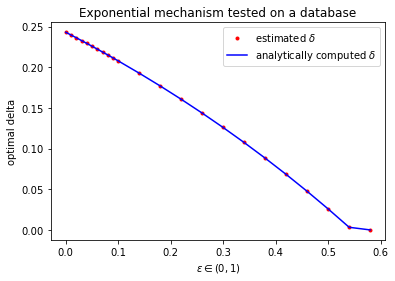

In [6]:
figfile_path = os.path.join(fig_dir, 'Exp.png')

test = 1 - np.exp(-0.5*(1-claimed_epsilon_list))

plt.title(r'Exponential mechanism tested on a database')
plt.xlabel(r"$\epsilon \in (0, 1)$")
plt.ylabel("optimal delta")

plt.plot(claimed_epsilon_list, estimated_delta , ".", color ="red", label=r"estimated $\delta$")
plt.plot(claimed_epsilon_list, theoretical_delta_list , color ="blue", label=r"analytically computed $\delta$")
plt.legend(loc='upper right')
plt.savefig(figfile_path, bbox_inches = 'tight', dpi = 150);
plt.show()